In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
import torch

from model import thalamocorticol_expansion as TCE
from model_slapik import VVS
from model_feedforward import feedforward_VVS as ffVVS

In [2]:
# read from cifar-10
with open("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/cifar-10-batches-py/data_batch_1", 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')

dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [3]:
data = torch.stack(
    [torch.Tensor(cv2.rotate(cv2.cvtColor(d.reshape((3, 32, 32)).T, cv2.COLOR_BGR2GRAY), cv2.ROTATE_90_CLOCKWISE).reshape((1, 32, 32))) for d in dict[b"data"]]
)
data = (data - data.mean()) / data.std()
data.shape

torch.Size([10000, 1, 32, 32])

## testing model_complexcells

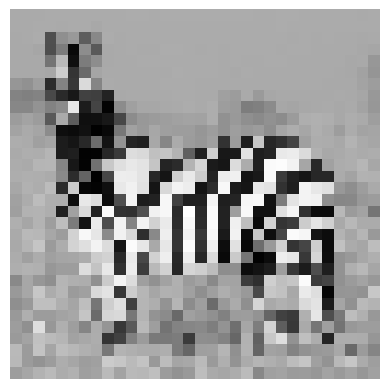

In [60]:
test_img = cv2.imread("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/zebra.jpg", 0)
test_img = cv2.resize(test_img, (32, 32))
#test_img = cv2.GaussianBlur(test_img, (3, 3), 0)
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.show()

In [61]:
model = VVS(input_shape=(1, 1, *test_img.shape), lgn_kernel_size=15, simple_kernel_size=15)
test_img = torch.reshape(torch.Tensor(test_img / 255.), (1, 1, 32, 32))

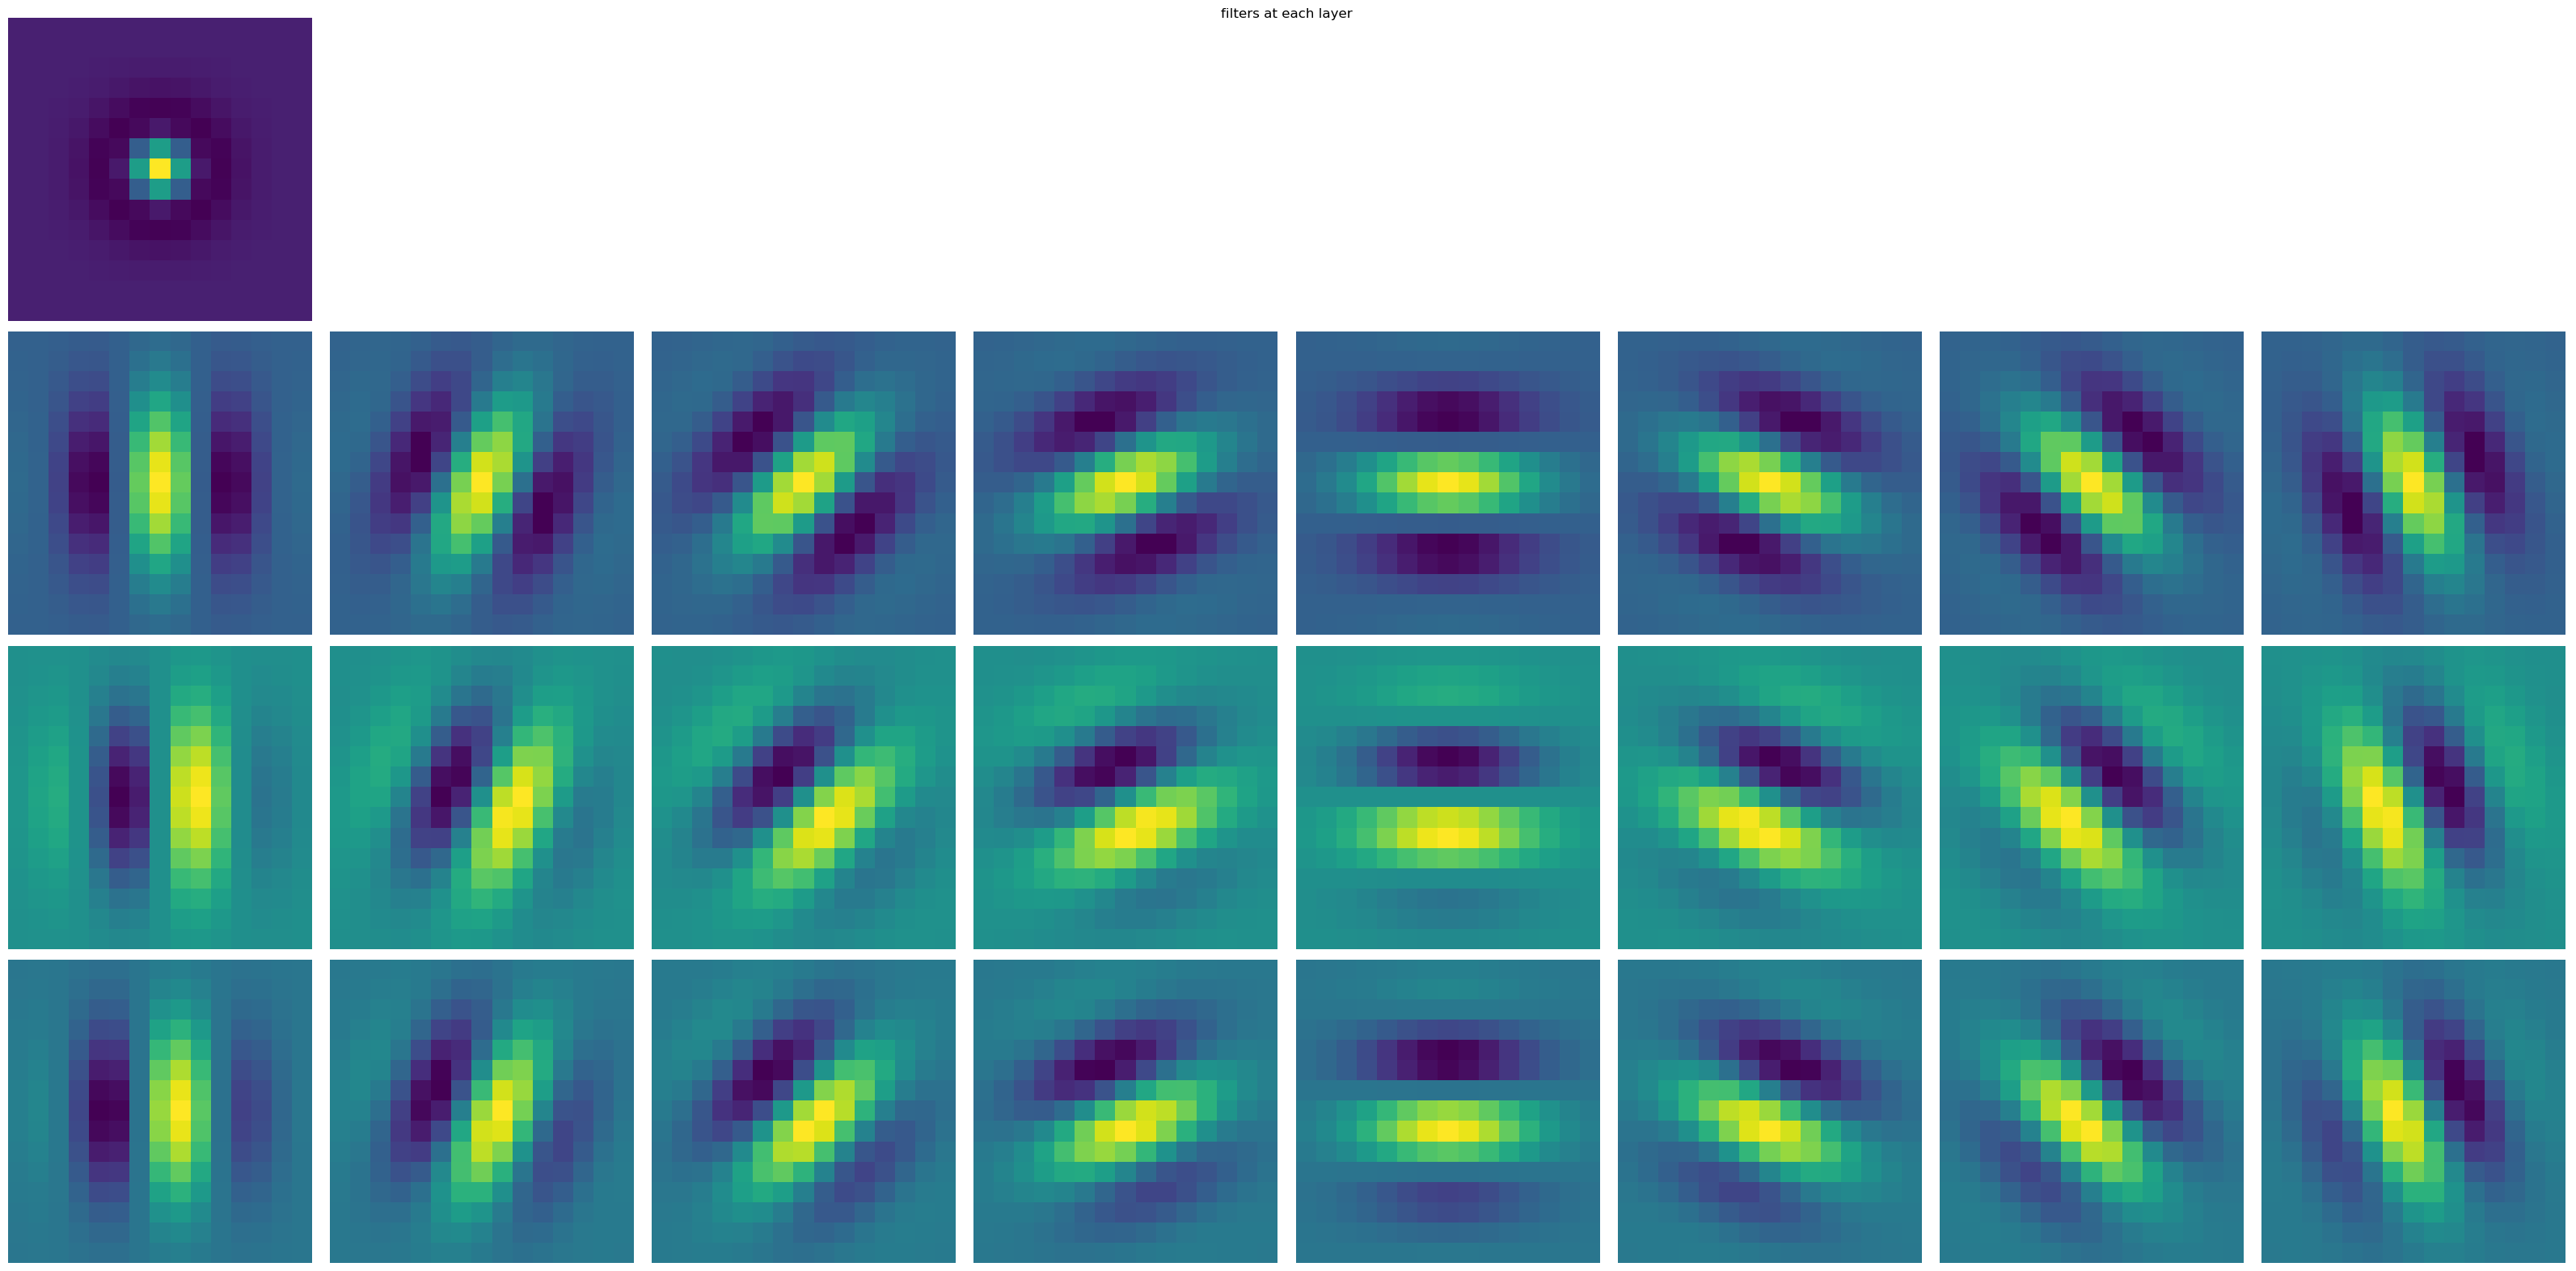

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(32, 15.5))

# lgn kernel
ax[0][0].imshow(model.lgn_kernel.reshape((model.lgn_kernel.shape[-1], model.lgn_kernel.shape[-1])))
ax[0][0].set_ylabel("lgn")

# simple even kernels
for i,k in enumerate(model.simple_even_kernels):
    ax[1][i].imshow(k.reshape((k.shape[-1], k.shape[-1])))
ax[1][0].set_ylabel("simple even cells")

# simple odd kernels
for i,k in enumerate(model.simple_odd_kernels):
    ax[2][i].imshow(k.reshape((k.shape[-1], k.shape[-1])))
ax[2][0].set_ylabel("simple odd cells")

# complex kernels (abstract)
for i,(k_e,k_o) in enumerate(zip(model.simple_even_kernels, model.simple_odd_kernels)):
    ax[3][i].imshow(k_e.reshape((k_e.shape[-1], k_e.shape[-1])) + k_o.reshape((k_o.shape[-1], k_o.shape[-1])))
ax[3][0].set_ylabel("complex cells")

# just turn off all the axes
for a in ax.ravel():
    a.set_axis_off()

plt.suptitle("filters at each layer")
fig.set_tight_layout(True)
plt.show()

In [63]:
y, act = model(test_img, "all")

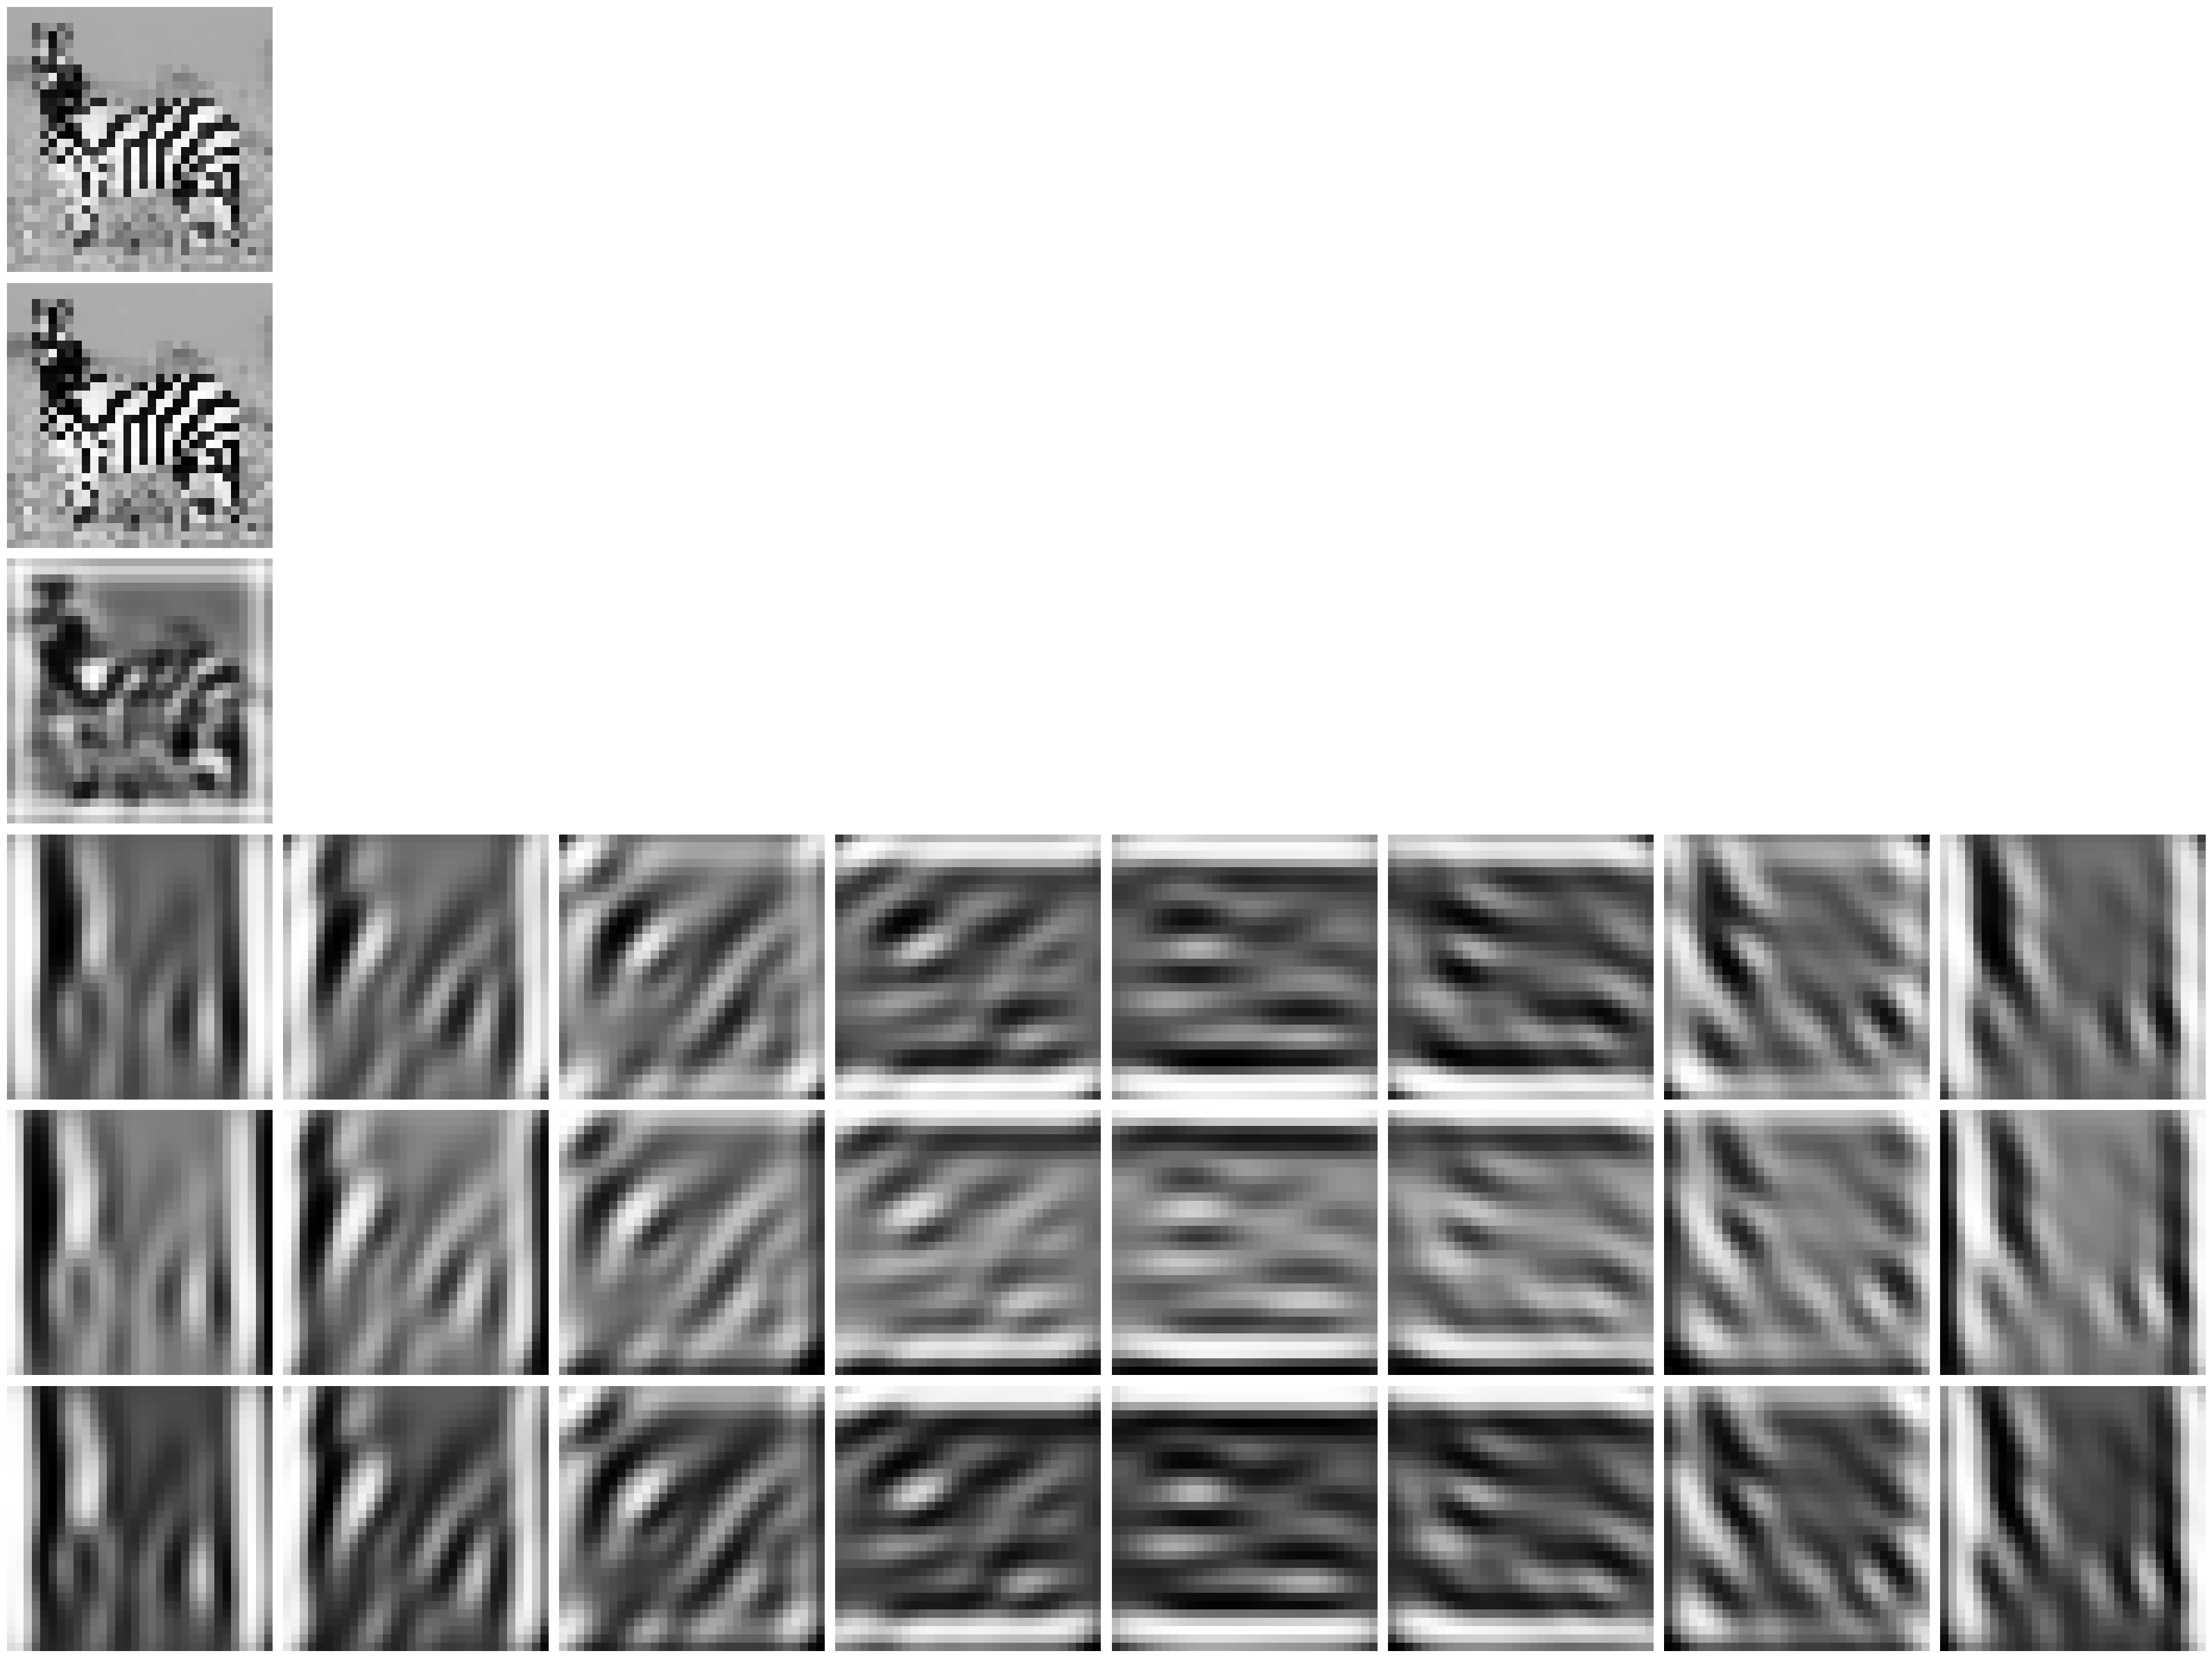

In [64]:
# unpack
retina_rep, lgn_rep, (se_rep, so_rep), complex_rep = act

# plot the activations
fig, ax = plt.subplots(6, 8, figsize=(32, 24))

# orig, retina, and lgn reps are easy
ax[0][0].imshow(test_img.reshape(test_img.shape[-1], test_img.shape[-1]), cmap="gray")
ax[0][0].set_ylabel("original")
ax[1][0].imshow(retina_rep.reshape(retina_rep.shape[-1], retina_rep.shape[-1]), cmap="gray")
ax[1][0].set_ylabel("retina")
ax[2][0].imshow(lgn_rep.reshape(lgn_rep.shape[-1], lgn_rep.shape[-1]), cmap="gray")
ax[2][0].set_ylabel("lgn")

# se rep
se_rep = torch.reshape(se_rep, (8, se_rep.shape[-1], se_rep.shape[-1]))
for i,rep in enumerate(se_rep):
    ax[3][i].imshow(rep, cmap="gray")
ax[3][0].set_ylabel("simple even")

# so rep
so_rep = torch.reshape(so_rep, (8, so_rep.shape[-1], so_rep.shape[-1]))
for i,rep in enumerate(so_rep):
    ax[4][i].imshow(rep, cmap="gray")
ax[4][0].set_ylabel("simple odd")

# complex rep
complex_rep = torch.reshape(complex_rep, (8, complex_rep.shape[-1], complex_rep.shape[-1]))
for i,rep in enumerate(complex_rep):
    ax[5][i].imshow(rep, cmap="gray")
ax[5][0].set_ylabel("complex")

# just turn off all the axes
for a in ax.ravel():
    a.set_axis_off()

fig.set_tight_layout(True)
plt.show()

## some prep for the test images

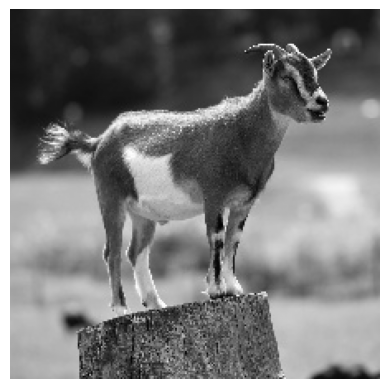

In [2]:
test_img = cv2.imread("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/goat.jpg", 0)
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.show()

In [3]:
test_img.shape

(224, 224)

In [ ]:
model = TCE(input_dim=(224,224), lgn_dim=(15.5,15.5), v1_dim=1024, device="cpu")
img_tensor = torch.Tensor(test_img / 255.)
x_lgn, x_v1 = model(img_tensor)

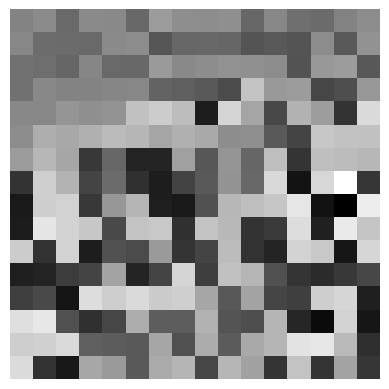

In [7]:
plt.imshow(x_lgn, cmap="gray")
plt.axis("off")
plt.show()

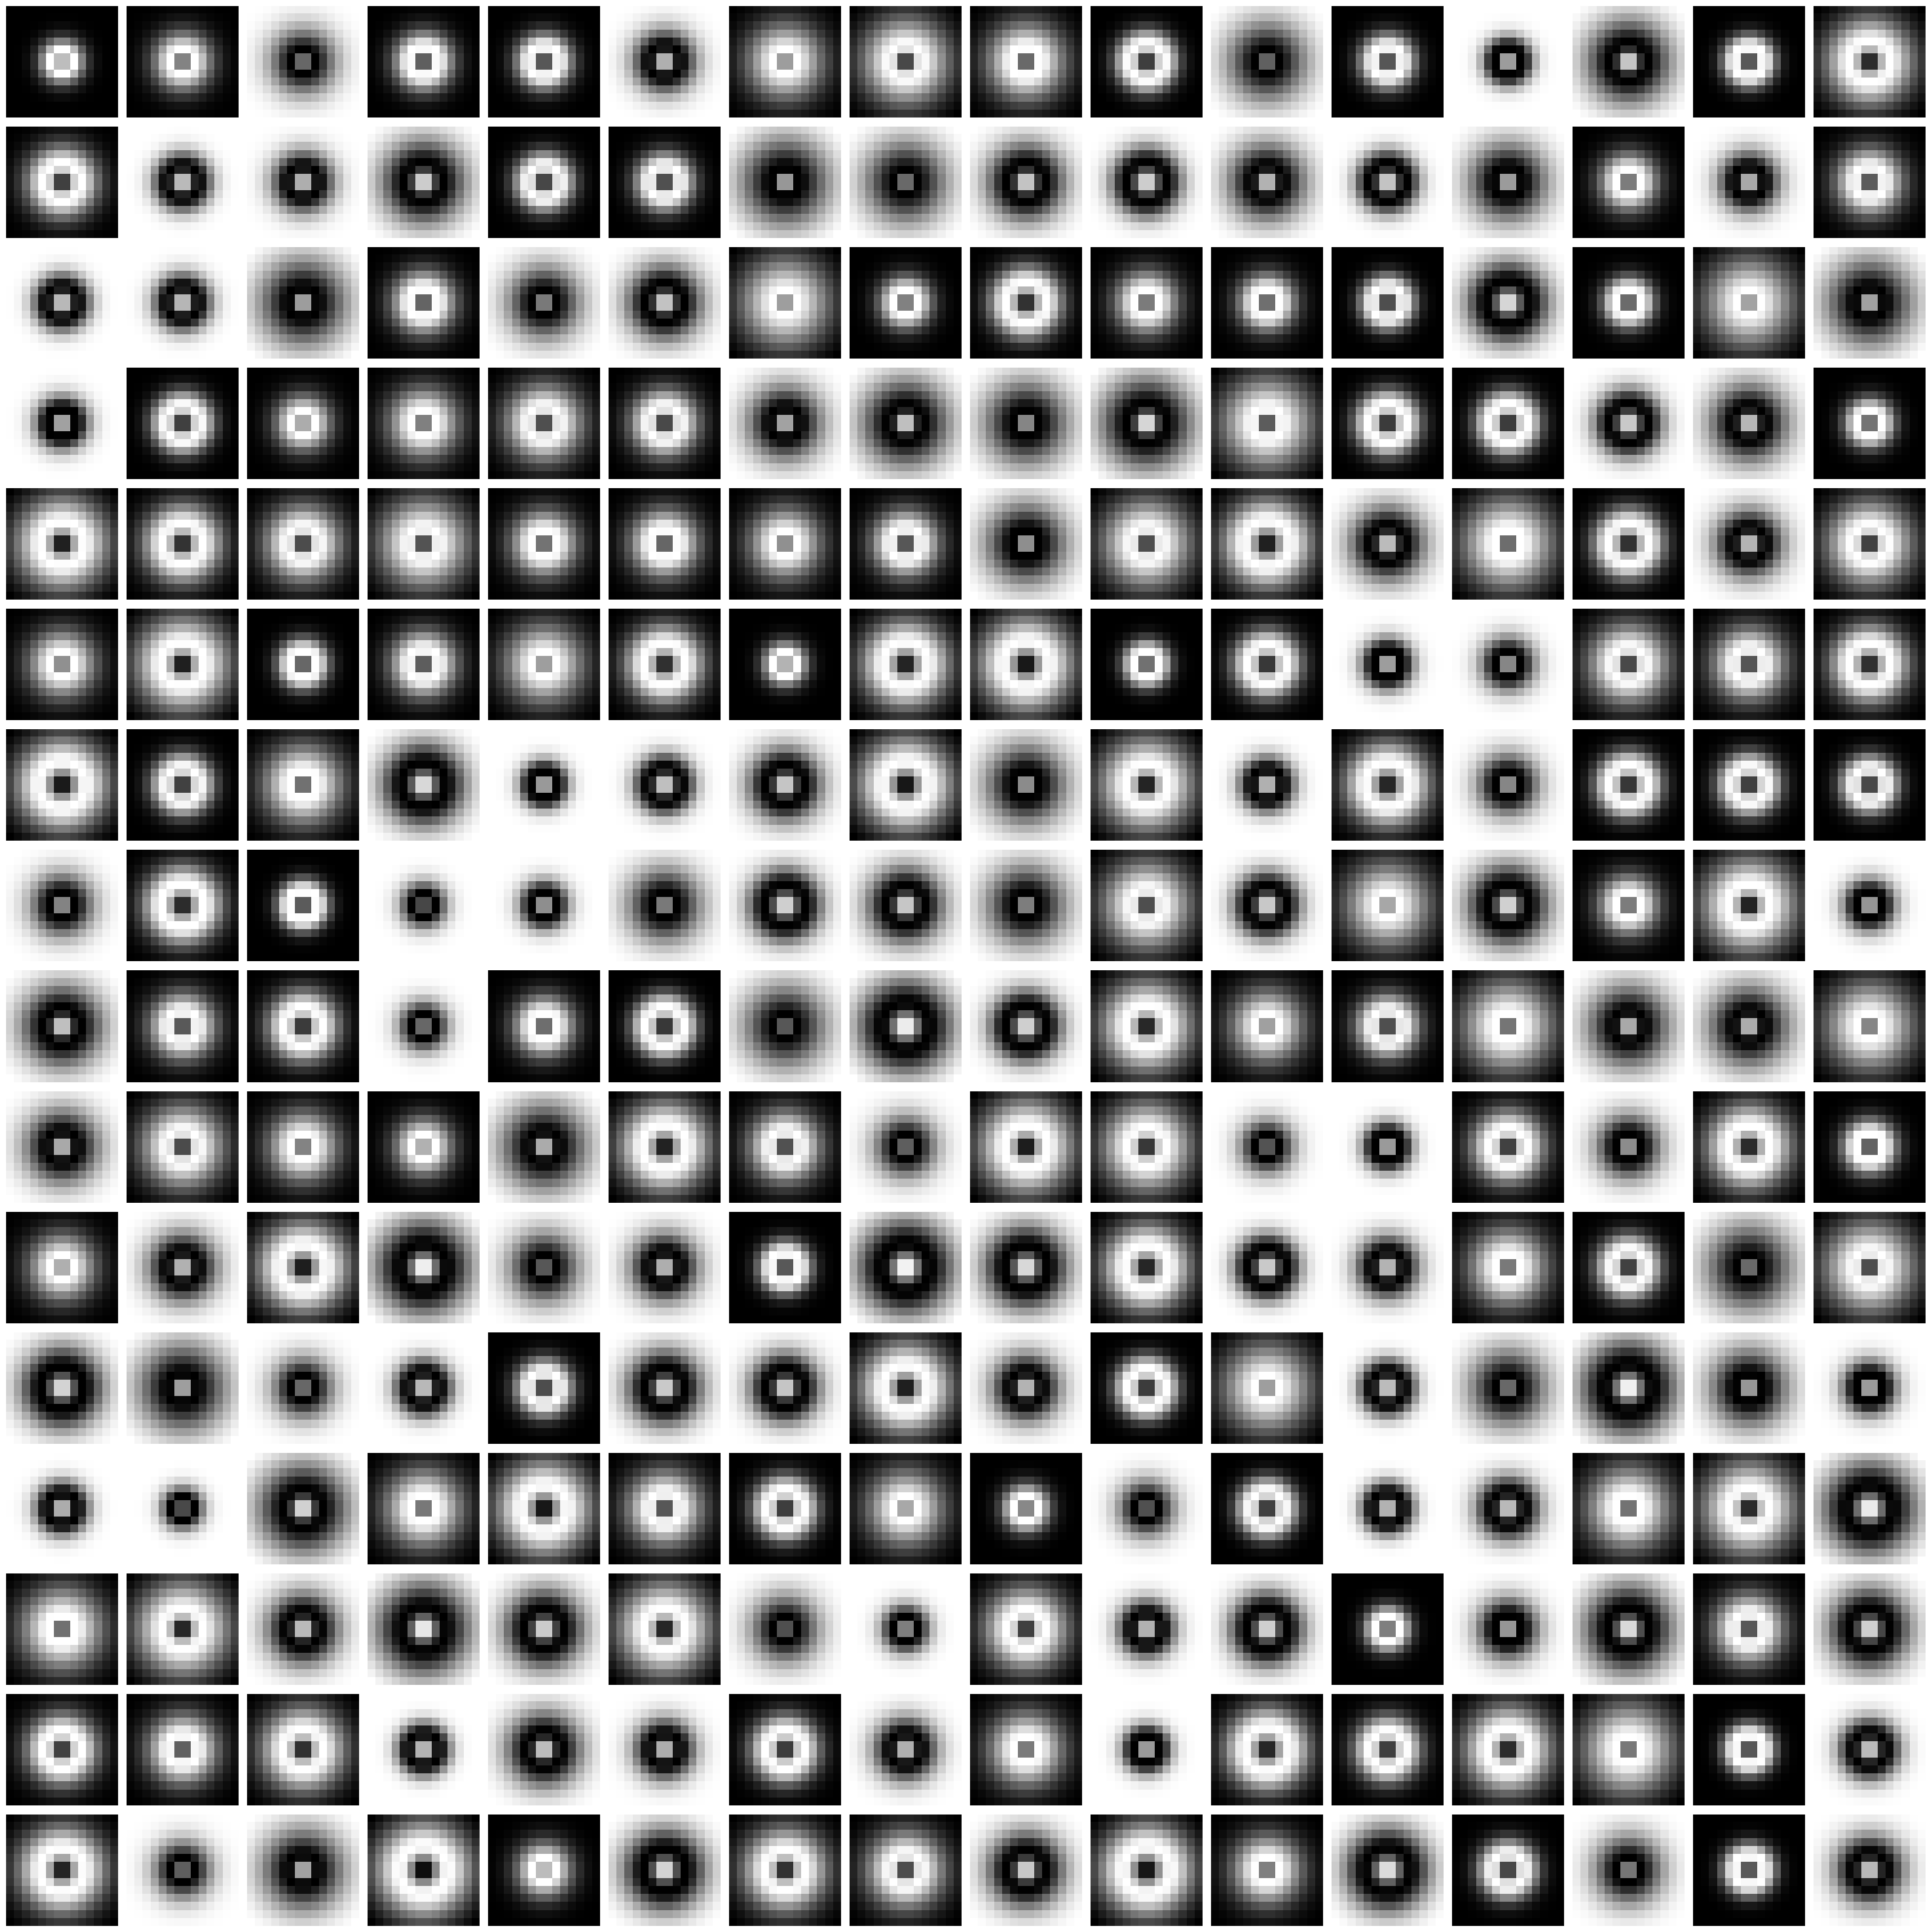

In [ ]:
fig, ax = plt.subplots((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, figsize=(32, 32))

# plot a few kernels
for i in range(16):
    for j in range(16):
        ax[i, j].imshow(model.lgn.kernels[i*16 + j], cmap="gray") #, vmin=-1, vmax=1)
        ax[i, j].axis("off")

fig.set_tight_layout(True)
plt.show()

In [9]:
x_v1.shape

torch.Size([1024])

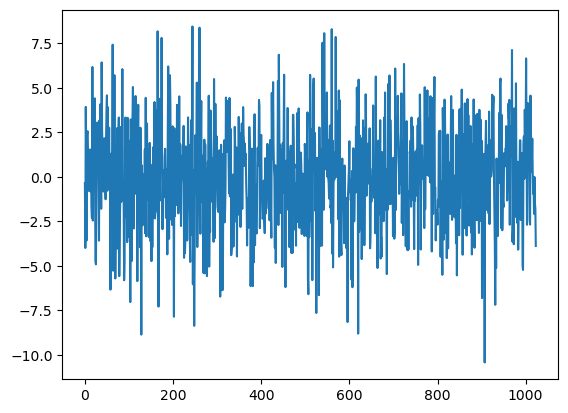

In [11]:
plt.plot(x_v1.detach().numpy())
plt.show()

In [3]:
# resize the test images so they are consistent
import glob

image_files = glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")
for f in image_files:
    img = cv2.imread(f)
    img_resized = cv2.resize(img, (224, 224))
    cv2.imwrite(f, img_resized)

## testing whether RGC-LGN produces gaussian features

In [3]:
# okay, i'd like to check if the RGC2LGN model properly produces a set of gaussian features
import torch 
import glob

test_imgs = [torch.Tensor(cv2.imread(f).T) for f in glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")]
print(f"Loaded {len(test_imgs)} test images.")
print(f"Each image has shape: {test_imgs[0].shape}") # should be (3, 224, 224)

R2L = RGC2LGN(sigmas=(0.8, 1.6, 3.2, 6.4, 12.8), kernel_size=None, channels=3)
lgn_rep = R2L(torch.stack(test_imgs)) # add batch dim
print(f"Output shape is {lgn_rep.shape}") # should be (5, 3 * 5 = 15) since 5 images, 3 channels * 5 sigmas

Loaded 5 test images.
Each image has shape: torch.Size([3, 224, 224])
Output shape is torch.Size([5, 15])


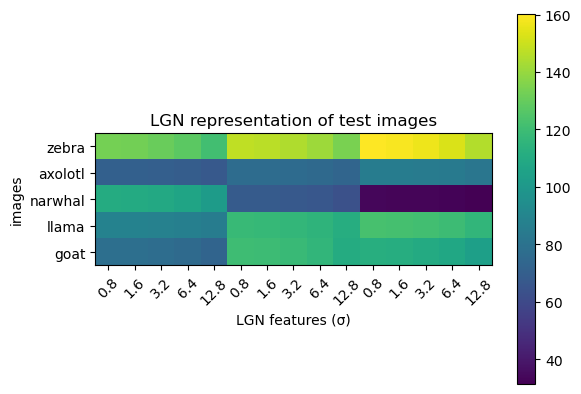

In [12]:
lgn_out_np = lgn_rep.detach().numpy()

plt.imshow(lgn_out_np, cmap='viridis')
plt.title("LGN representation of test images")
plt.ylabel("images")
plt.yticks(ticks=np.arange(len(test_imgs)), labels=[f.split("/")[-1].split(".")[0] for f in glob.glob("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/*.jpg")])
plt.xlabel("LGN features (σ)")
plt.xticks(ticks=np.arange(lgn_out_np.shape[1]), labels=[f"{sigma:.1f}" for sigma in [0.8, 1.6, 3.2, 6.4, 12.8] * 3], rotation=45)
plt.colorbar()
plt.show()

In [22]:
from utils import Utils as u
triplets, labels = u.load_mat("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/digits/triplet_digits_2.mat", mat_key="triplets")

In [ ]:
labels[0][69005]

np.uint8(2)

## loading data

In [ ]:
# let's load the training data to a train/val/test torch datasets/loaders
from train import TripletDataset

np.random.seed(1234)
triplets = u.load_mat(
                      "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/natural_movies/triplet_patches.mat", 
                      mat_key="allPatches") # triplets, labels = u.load_mat(args.data, mat_key=args.data_key)
indices = np.random.permutation(len(triplets))
train_size, val_size = int(0.7 * len(triplets)), int(0.1 * len(triplets))
train_data = TripletDataset(triplets[indices[:train_size]])
val_data = TripletDataset(triplets[indices[train_size:train_size + val_size]])
test_data = TripletDataset(triplets[indices[train_size + val_size:]])
print("training datasets properly loaded...")

print(triplets.shape)

## Testing non-decreasing loss function

In [1]:
import pickle
import matplotlib.pyplot as plt

In [5]:
filename = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M0p1_V1256_EP200.pkl"
with open(filename, 'rb') as f:
    metrics = pickle.load(f)
metrics.keys()

dict_keys(['train_losses', 'val_losses', 'train_triplet_losses', 'val_triplet_losses', 'train_l1_norms', 'val_l1_norms', 'train_viol', 'val_viol', 'train_time', 'best_epoch'])

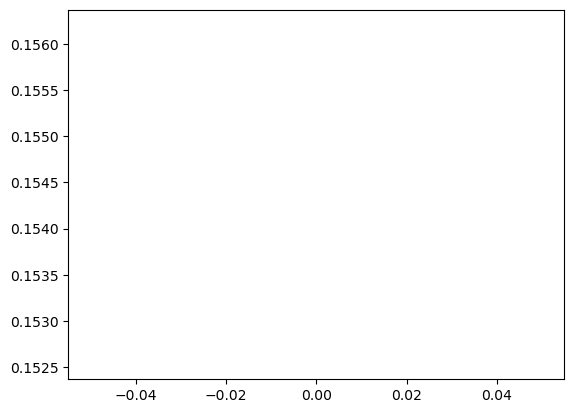

In [6]:
plt.plot(metrics["train_losses"], "k--")
plt.plot(metrics["val_losses"], "b--")
plt.show()

In [7]:
metrics["train_losses"]

[0.1561880044543765, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

## Testing separate activations

In [6]:
model = VVS(input_shape=data[:8].shape, simple_offset=np.pi/4)

In [16]:
# let's run as normal - feed forward
(r, l, s, c) = model.forward(data[:8], "all")

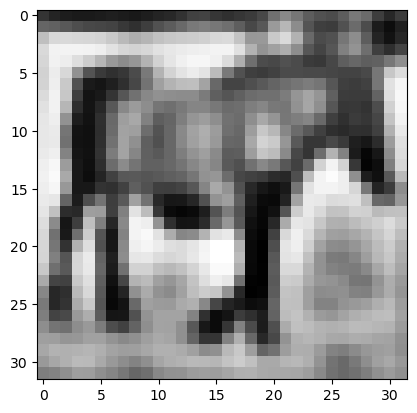

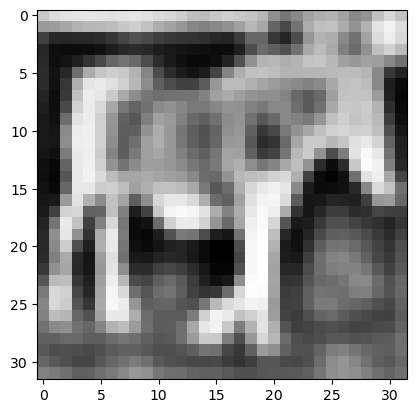

In [12]:
for rep in l:
    plt.imshow(*rep[7].detach().cpu().numpy(), cmap="gray")
    plt.show()

In [8]:
# let's step through each step of the model to get each activation separately
x = data[:8].view(1, model.B * model.C, model.H, model.W)

retina_rep = model.norm( model.retina(x) )
lgn_rep = model.norm( model.lgn(x) )
simple_rep = model.norm( model.simple(x) )
complex_rep = model.norm( model.complex(simple_rep, x) )

# now let's reshape each of these to be (B, C, H, W)
retina_rep = retina_rep.view(model.B, model.C, model.H, model.W)
lgn_rep = lgn_rep.view(model.B, model.C, model.H, model.W)
simple_rep = simple_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)
complex_rep = complex_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)

In [19]:
l[0].shape

torch.Size([8, 1, 32, 32])

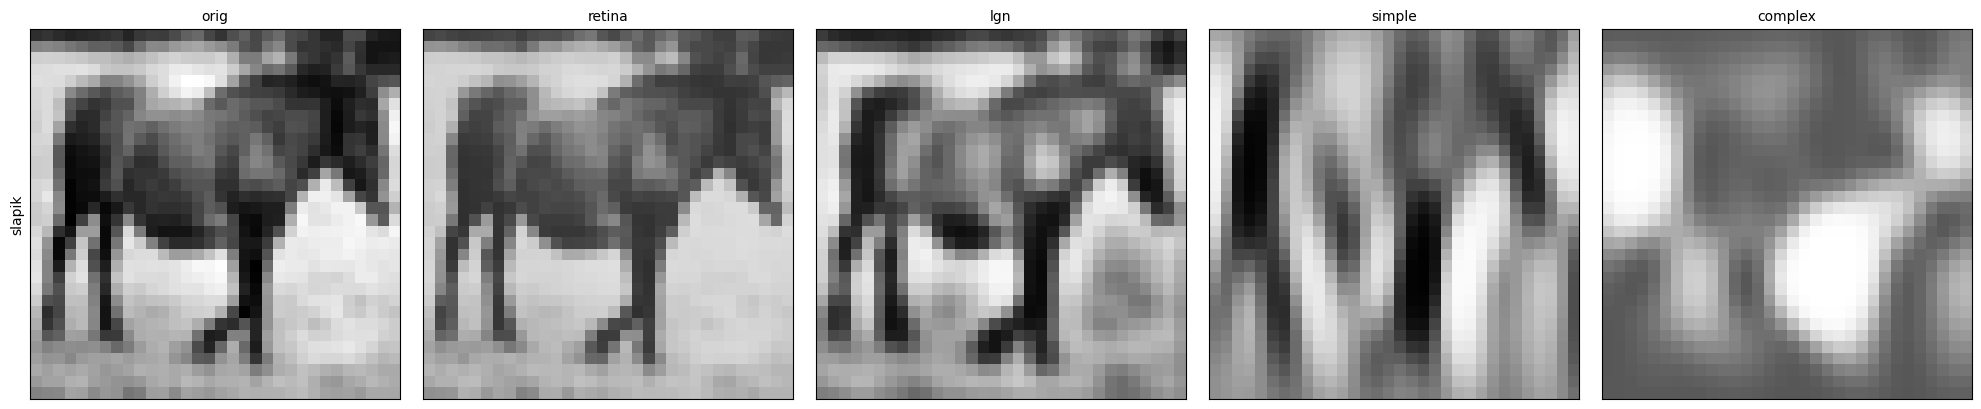

In [23]:
# let's plot the two side by side
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(*data[7], cmap="gray")
ax[0].set_ylabel("slapik", fontsize=10)
ax[0].set_title("orig", fontsize=10)

ax[1].imshow(*r[7], cmap="gray", vmin=0, vmax=1)
ax[1].set_title("retina", fontsize=10)

ax[2].imshow(*l[0][7], cmap="gray", vmin=0, vmax=1)
ax[2].set_title("lgn", fontsize=10)

ax[3].imshow(s[7][0], cmap="gray", vmin=0, vmax=1)
ax[3].set_title("simple", fontsize=10)

ax[4].imshow(c[7][0], cmap="gray", vmin=0, vmax=1)
ax[4].set_title("complex", fontsize=10)

# remove the x and y ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.set_tight_layout(True)
plt.show()

NameError: name 'retina_rep' is not defined

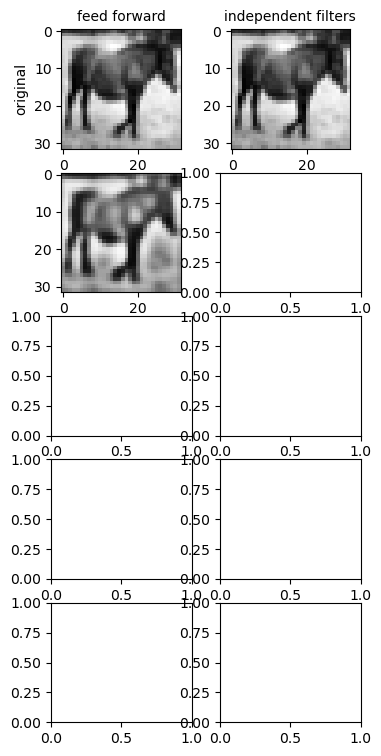

In [13]:
# let's plot the two side by side
fig, ax = plt.subplots(5, 2, figsize=(4, 9))

ax[0][0].imshow(*data[7], cmap="gray")
ax[0][1].imshow(*data[7], cmap="gray")
ax[0][0].set_ylabel("original", fontsize=10)
ax[0][0].set_title("feed forward", fontsize=10)
ax[0][1].set_title("independent filters", fontsize=10)

ax[1][0].imshow(*r[7], cmap="gray", vmin=0, vmax=1)
ax[1][1].imshow(*retina_rep[7], cmap="gray", vmin=0, vmax=1)
ax[1][0].set_ylabel("retina", fontsize=10)

ax[2][0].imshow(*l[7], cmap="gray", vmin=0, vmax=1)
ax[2][1].imshow(*lgn_rep[7], cmap="gray", vmin=0, vmax=1)
ax[2][0].set_ylabel("lgn", fontsize=10)

ax[3][0].imshow(s[7][0], cmap="gray", vmin=0, vmax=1)
ax[3][1].imshow(simple_rep[7][0], cmap="gray", vmin=0, vmax=1)
ax[3][0].set_ylabel("simple", fontsize=10)

ax[4][0].imshow(c[7][0], cmap="gray", vmin=0, vmax=1)
ax[4][1].imshow(complex_rep[7][0], cmap="gray", vmin=0, vmax=1)
ax[4][0].set_ylabel("complex", fontsize=10)

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.set_tight_layout(True)
plt.show()

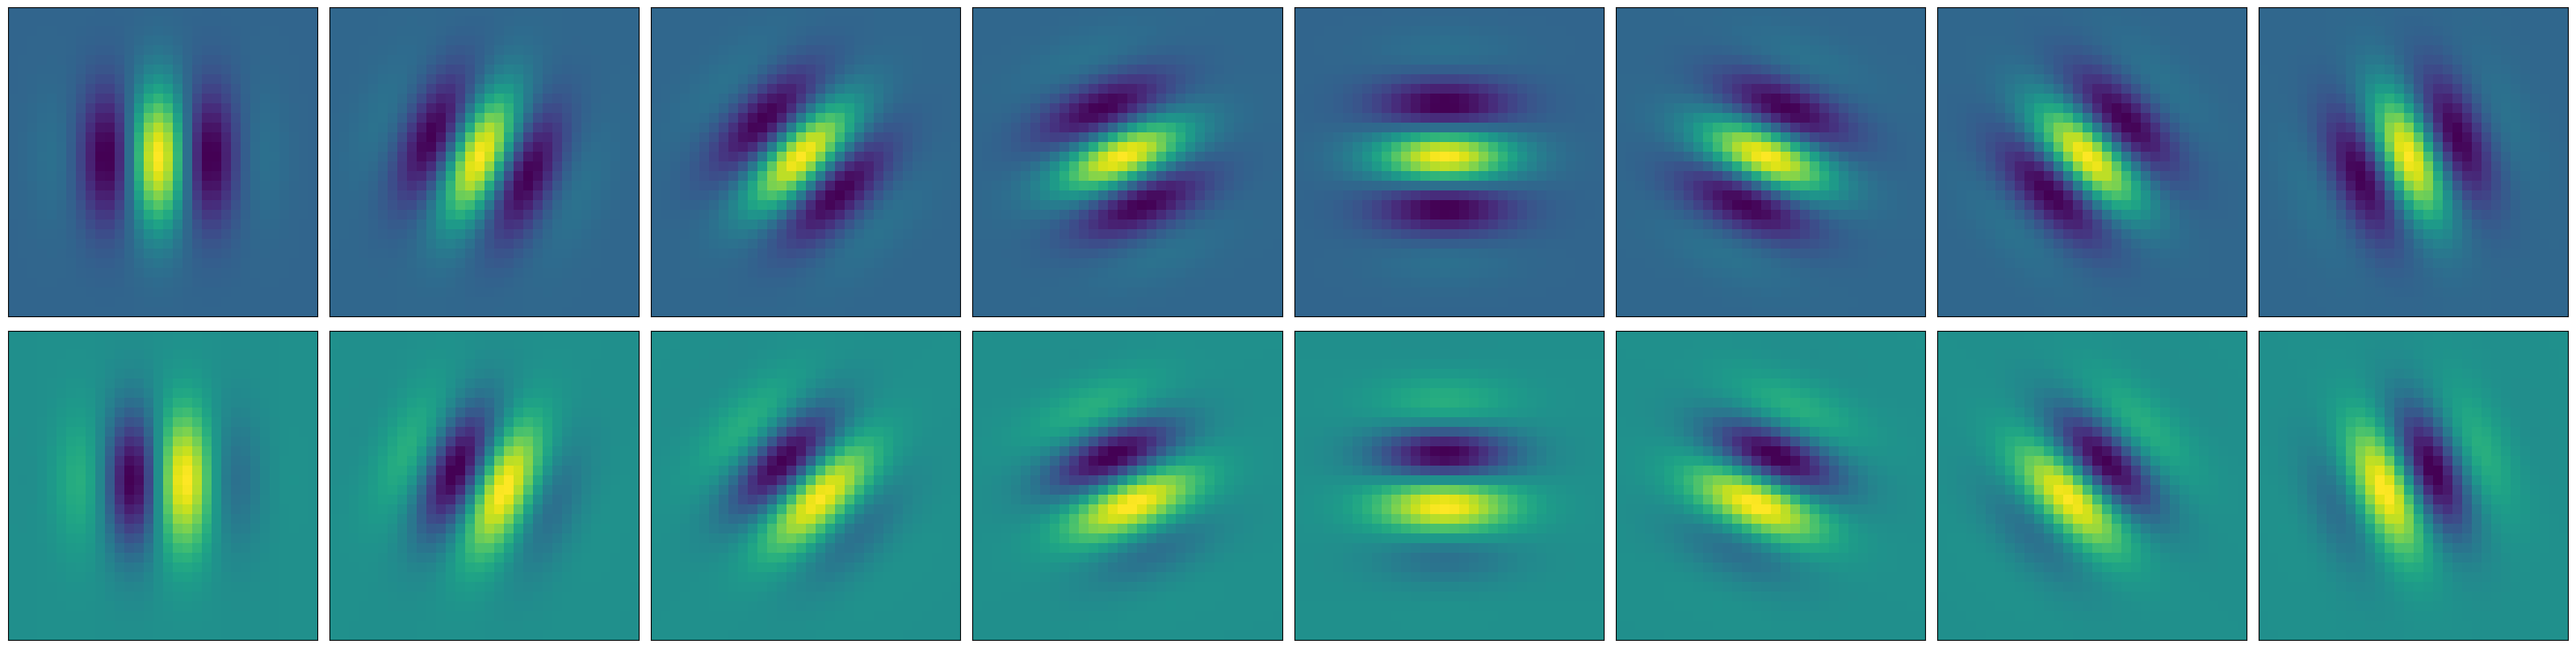

In [10]:
# lets test these with a few gabor functions
# for ease, im just going to instantiate the VVS model with larger kernel sizes and grab the kernels
VVS_kernels = VVS(input_shape=(1,1,64,64), lgn_kernel_size=32, simple_kernel_size=32, n_simple_cell_types=8, 
    simple_sx=5, simple_sy=5, spatial_freq=0.5, simple_offset=0
    )
even_gabors = VVS_kernels.simple_even_kernels
odd_gabors = VVS_kernels.simple_odd_kernels

fig, ax = plt.subplots(2, 8, figsize=(32, 8.5))

# plot the evens
for i,g in enumerate(even_gabors):
    ax[0][i].imshow(*g)

# plot the odds
for i,g in enumerate(odd_gabors):
    ax[1][i].imshow(*g)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

fig.set_tight_layout(True)
plt.show()

In [11]:
even_gabors.shape, odd_gabors.shape

(torch.Size([8, 1, 32, 32]), torch.Size([8, 1, 32, 32]))

In [12]:
# okay, let's pass these through the model (both feed forward and independently)
_, (r, l, s, c) = model(even_gabors, "all")

x = even_gabors.view(1, model.B * model.C, model.H, model.W)
retina_rep = model.norm( model.retina(x) )
lgn_rep = model.norm( model.lgn(x) )
simple_rep = model.norm( model.simple(x) )
complex_rep = model.norm( model.complex(simple_rep, x) )

# now let's reshape each of these to be (B, C, H, W)
retina_rep = retina_rep.view(model.B, model.C, model.H, model.W)
lgn_rep = lgn_rep.view(model.B, model.C, model.H, model.W)
simple_rep = simple_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)
complex_rep = complex_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)

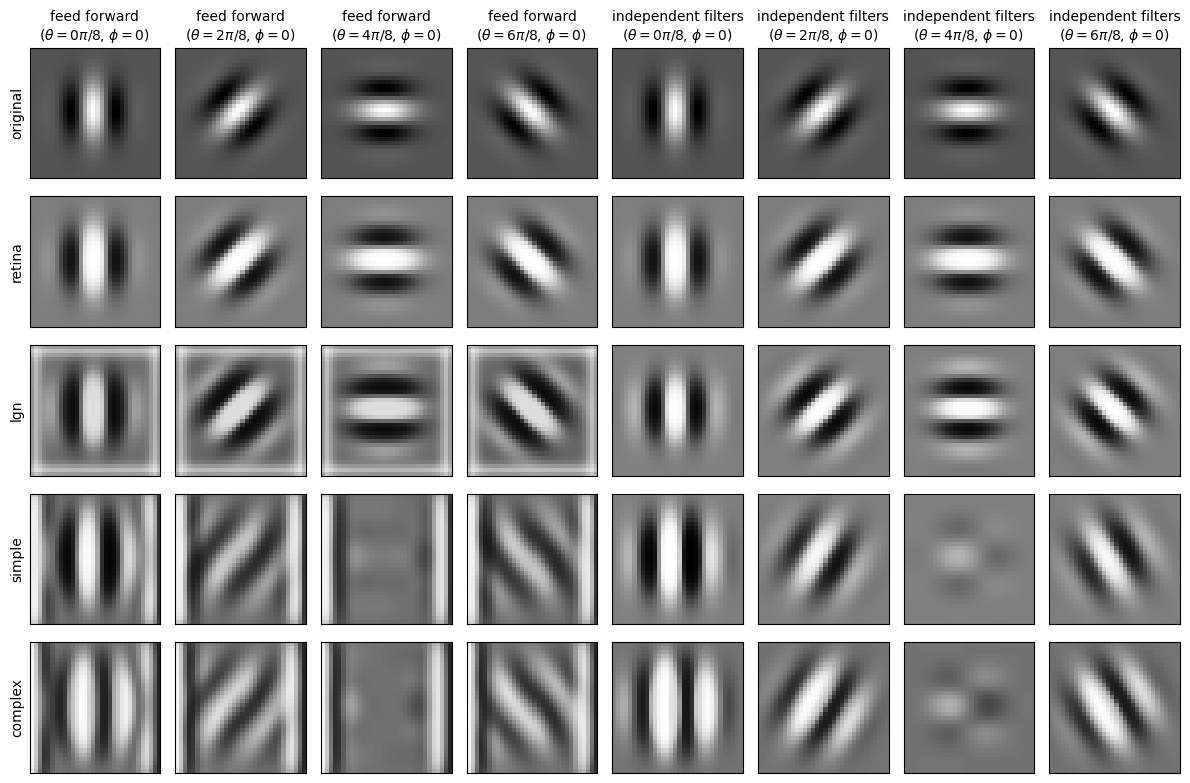

In [13]:
# let's plot the two side by side
fig, ax = plt.subplots(5, 8, figsize=(3*4, 8))

for n,i in enumerate([0, 2, 4, 6]):
    ax[0][i//2].imshow(*even_gabors[i], cmap="gray")
    ax[0][i+4-n].imshow(*even_gabors[i], cmap="gray")
    ax[0][i//2].set_title("feed forward\n"+rf"($\theta={i}\pi/8$, $\phi=0$)", fontsize=10)
    ax[0][i+4-n].set_title("independent filters\n"+rf"($\theta={i}\pi/8$, $\phi=0$)", fontsize=10)

    ax[1][i//2].imshow(*r[i], cmap="gray", vmin=0, vmax=1)
    ax[1][i+4-n].imshow(*retina_rep[i], cmap="gray", vmin=0, vmax=1)

    ax[2][i//2].imshow(*l[i], cmap="gray", vmin=0, vmax=1)
    ax[2][i+4-n].imshow(*lgn_rep[i], cmap="gray", vmin=0, vmax=1)

    ax[3][i//2].imshow(s[i][0], cmap="gray", vmin=0, vmax=1)
    ax[3][i+4-n].imshow(simple_rep[i][0], cmap="gray", vmin=0, vmax=1)

    ax[4][i//2].imshow(c[i][0], cmap="gray", vmin=0, vmax=1)
    ax[4][i+4-n].imshow(complex_rep[i][0], cmap="gray", vmin=0, vmax=1)

# set the ylabels
ax[0][0].set_ylabel("original", fontsize=10)
ax[1][0].set_ylabel("retina", fontsize=10)
ax[2][0].set_ylabel("lgn", fontsize=10)
ax[3][0].set_ylabel("simple", fontsize=10)
ax[4][0].set_ylabel("complex", fontsize=10)

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.set_tight_layout(True)
plt.show()

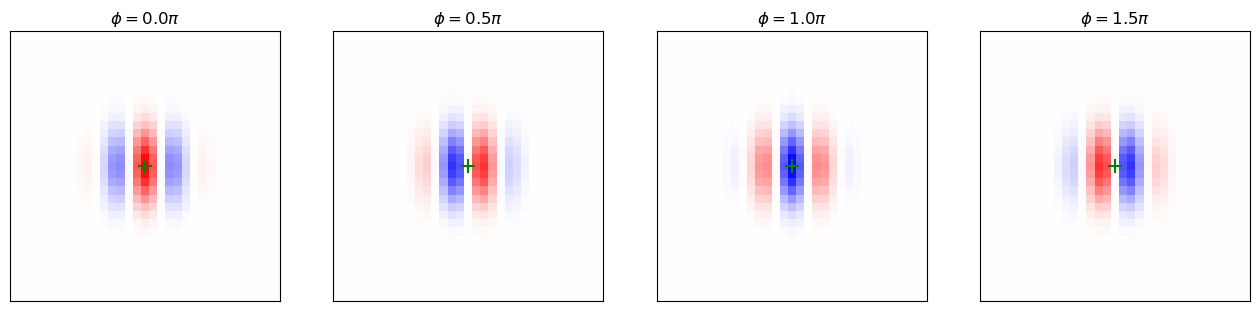

In [14]:
phis = [0, np.pi/2, np.pi, 3*np.pi/2]
even_gabors = torch.stack([VVS(input_shape=(4,1,33,33), lgn_kernel_size=33, simple_kernel_size=33, simple_offset=phi).simple_even_kernels[0] for phi in phis])

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i,a in enumerate(ax):
    a.imshow(*even_gabors[i], cmap="bwr", vmin=even_gabors.min(), vmax=even_gabors.max())
    a.scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, c="g", marker="+", s=100)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(rf"$\phi={phis[i]/np.pi}\pi$")

plt.show()

In [15]:
even_gabors.shape

torch.Size([4, 1, 33, 33])

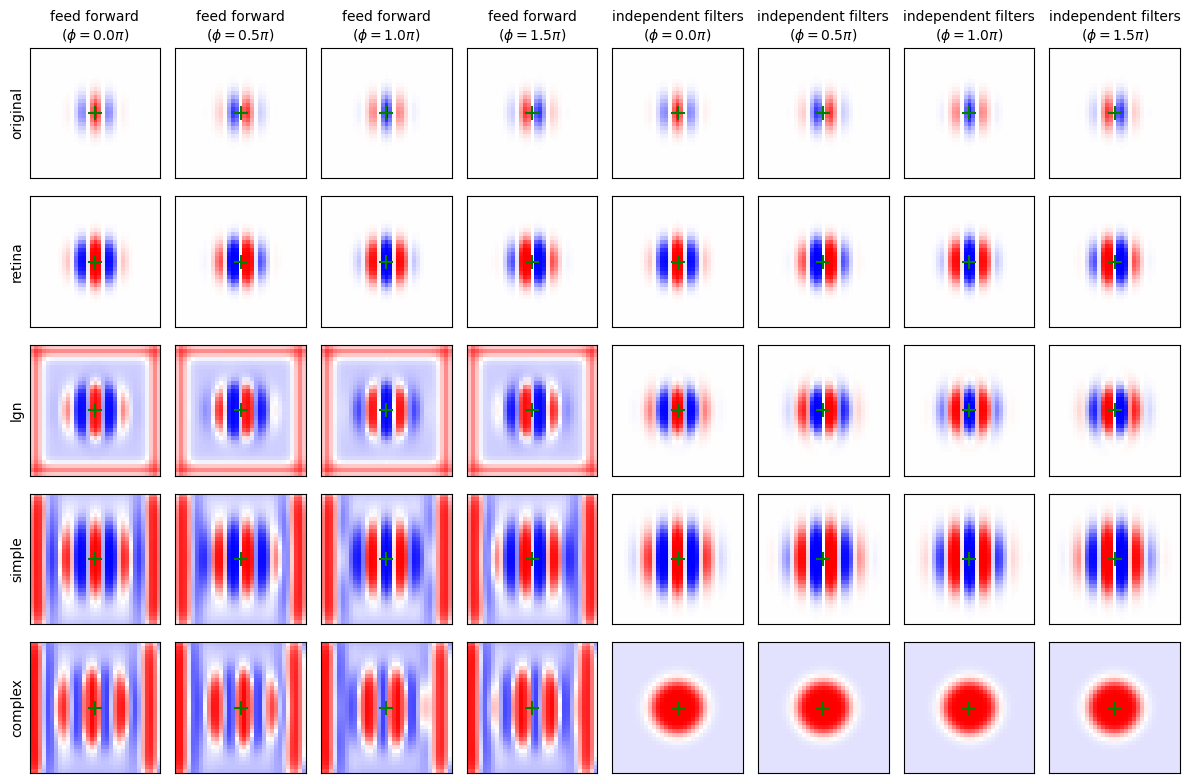

In [ ]:
# instantiate the model
model = VVS(input_shape=even_gabors.shape, lgn_kernel_size=33, simple_kernel_size=33)

# run the feed forward model
_, (r, l, s, c) = model(even_gabors, "all")

# let's step through each step of the model to get each activation separately
x = even_gabors.view(1, model.B * model.C, model.H, model.W)
retina_rep = model.norm( model.retina(x) )
lgn_rep = model.norm( model.lgn(x) )
simple_rep = model.norm( model.simple(x) )
complex_rep = model.norm( model.complex(x, flag="independent") )

# now let's reshape each of these to be (B, C, H, W)
retina_rep = retina_rep.view(model.B, model.C, model.H, model.W)
lgn_rep = lgn_rep.view(model.B, model.C, model.H, model.W)
simple_rep = simple_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)
complex_rep = complex_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)

# let's plot the two side by side
fig, ax = plt.subplots(5, 8, figsize=(12, 8))

for i,g in enumerate(even_gabors):
    ax[0][i].imshow(*even_gabors[i], cmap="bwr", vmin=even_gabors.min(), vmax=even_gabors.max())
    ax[0][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[0][i+4].imshow(*even_gabors[i], cmap="bwr", vmin=even_gabors.min(), vmax=even_gabors.max())
    ax[0][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[0][i].set_title("feed forward\n"+rf"($\phi={phis[i]/np.pi}\pi$)", fontsize=10)
    ax[0][i+4].set_title("independent filters\n"+rf"($\phi={phis[i]/np.pi}\pi$)", fontsize=10)

    ax[1][i].imshow(*r[i], cmap="bwr", vmin=0, vmax=1)
    ax[1][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[1][i+4].imshow(*retina_rep[i], cmap="bwr", vmin=0, vmax=1)
    ax[1][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[2][i].imshow(*l[i], cmap="bwr", vmin=0, vmax=1)
    ax[2][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[2][i+4].imshow(*lgn_rep[i], cmap="bwr", vmin=0, vmax=1)
    ax[2][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[3][i].imshow(s[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[3][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[3][i+4].imshow(simple_rep[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[3][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[4][i].imshow(c[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[4][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[4][i+4].imshow(complex_rep[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[4][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

# set the ylabels
ax[0][0].set_ylabel("original", fontsize=10)
ax[1][0].set_ylabel("retina", fontsize=10)
ax[2][0].set_ylabel("lgn", fontsize=10)
ax[3][0].set_ylabel("simple", fontsize=10)
ax[4][0].set_ylabel("complex", fontsize=10)

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.set_tight_layout(True)
plt.show()

In [ ]:
# prediction: simple cells will be checkerboard pattern and the complex cells will washed out.
horiz_even_gabors = torch.rot90(even_gabors, 1, [2, 3])

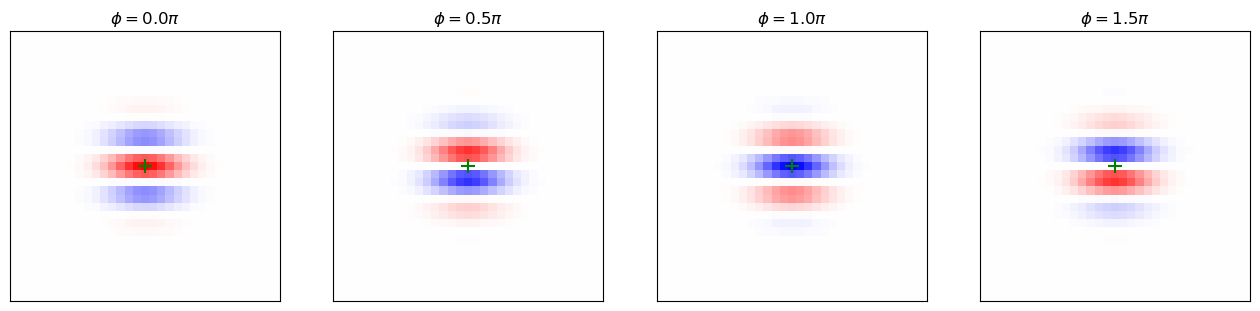

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i,a in enumerate(ax):
    a.imshow(*horiz_even_gabors[i], cmap="bwr", vmin=horiz_even_gabors.min(), vmax=horiz_even_gabors.max())
    a.scatter((horiz_even_gabors[i].shape[1]-1)//2, (horiz_even_gabors[i].shape[1]-1)//2, c="g", marker="+", s=100)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(rf"$\phi={phis[i]/np.pi}\pi$")

plt.show()

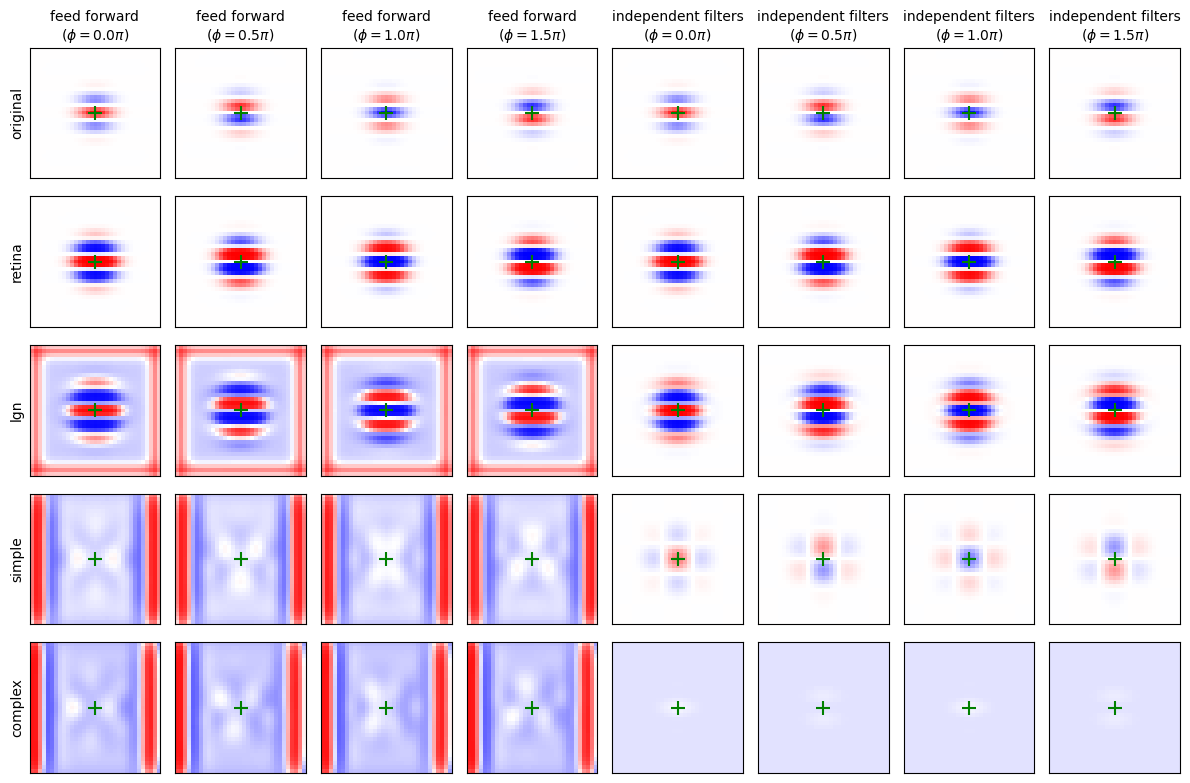

In [21]:
# let's try this with horizontal gabors
_, (r, l, s, c) = model(horiz_even_gabors, "all")

# let's step through each step of the model to get each activation separately
x = horiz_even_gabors.view(1, model.B * model.C, model.H, model.W)
retina_rep = model.norm( model.retina(x) )
lgn_rep = model.norm( model.lgn(x) )
simple_rep = model.norm( model.simple(x) )
complex_rep = model.norm( model.complex(x, flag="independent") )

# now let's reshape each of these to be (B, C, H, W)
retina_rep = retina_rep.view(model.B, model.C, model.H, model.W)
lgn_rep = lgn_rep.view(model.B, model.C, model.H, model.W)
simple_rep = simple_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)
complex_rep = complex_rep.view(model.B, model.C * model.theta.shape[0], model.H, model.W)

# let's plot the two side by side
fig, ax = plt.subplots(5, 8, figsize=(12, 8))

for i,g in enumerate(horiz_even_gabors):
    ax[0][i].imshow(*horiz_even_gabors[i], cmap="bwr", vmin=horiz_even_gabors.min(), vmax=horiz_even_gabors.max())
    ax[0][i].scatter((horiz_even_gabors[i].shape[1]-1)//2, (horiz_even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[0][i+4].imshow(*horiz_even_gabors[i], cmap="bwr", vmin=horiz_even_gabors.min(), vmax=horiz_even_gabors.max())
    ax[0][i+4].scatter((horiz_even_gabors[i].shape[1]-1)//2, (horiz_even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[0][i].set_title("feed forward\n"+rf"($\phi={phis[i]/np.pi}\pi$)", fontsize=10)
    ax[0][i+4].set_title("independent filters\n"+rf"($\phi={phis[i]/np.pi}\pi$)", fontsize=10)

    ax[1][i].imshow(*r[i], cmap="bwr", vmin=0, vmax=1)
    ax[1][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[1][i+4].imshow(*retina_rep[i], cmap="bwr", vmin=0, vmax=1)
    ax[1][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[2][i].imshow(*l[i], cmap="bwr", vmin=0, vmax=1)
    ax[2][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[2][i+4].imshow(*lgn_rep[i], cmap="bwr", vmin=0, vmax=1)
    ax[2][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[3][i].imshow(s[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[3][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[3][i+4].imshow(simple_rep[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[3][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

    ax[4][i].imshow(c[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[4][i].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)
    ax[4][i+4].imshow(complex_rep[i][0], cmap="bwr", vmin=0, vmax=1)
    ax[4][i+4].scatter((even_gabors[i].shape[1]-1)//2, (even_gabors[i].shape[1]-1)//2, marker='+', c="green", s=100)

# set the ylabels
ax[0][0].set_ylabel("original", fontsize=10)
ax[1][0].set_ylabel("retina", fontsize=10)
ax[2][0].set_ylabel("lgn", fontsize=10)
ax[3][0].set_ylabel("simple", fontsize=10)
ax[4][0].set_ylabel("complex", fontsize=10)

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
fig.set_tight_layout(True)
plt.show()

## testing feedforward_VVS

In [4]:
model = ffVVS(input_shape=(8, 1, 225, 225))

# just want to check that our shapes are correct
img = torch.Tensor(cv2.imread("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/test_images/zebra.jpg", 0)).unsqueeze(0)
l, s = model.forward(data[7])
print(l.shape, s.shape)

torch.Size([2, 30, 30]) torch.Size([16, 14, 14])


[W203 11:50:56.321983000 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


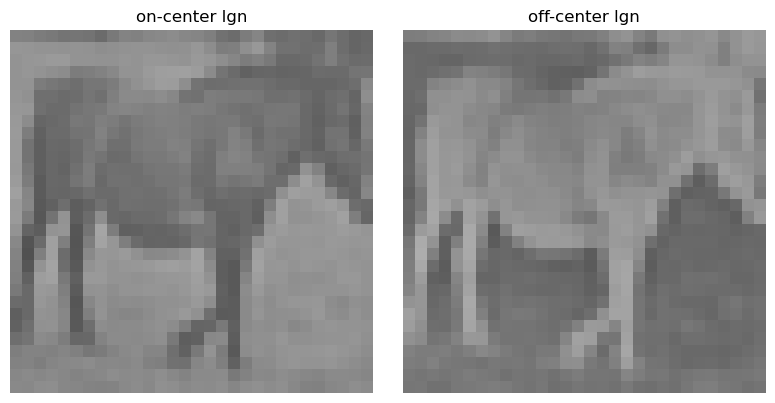

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(l[0], cmap="gray", vmin=0, vmax=1)
ax[0].set_title("on-center lgn")

"""ax[1].imshow(-l[0], cmap="gray")
ax[1].set_title("negative on-center lgn")"""

ax[1].imshow(l[1], cmap="gray", vmin=0, vmax=1)
ax[1].set_title("off-center lgn")

for a in ax:
    a.axis("off")

fig.set_tight_layout(True)
plt.show()

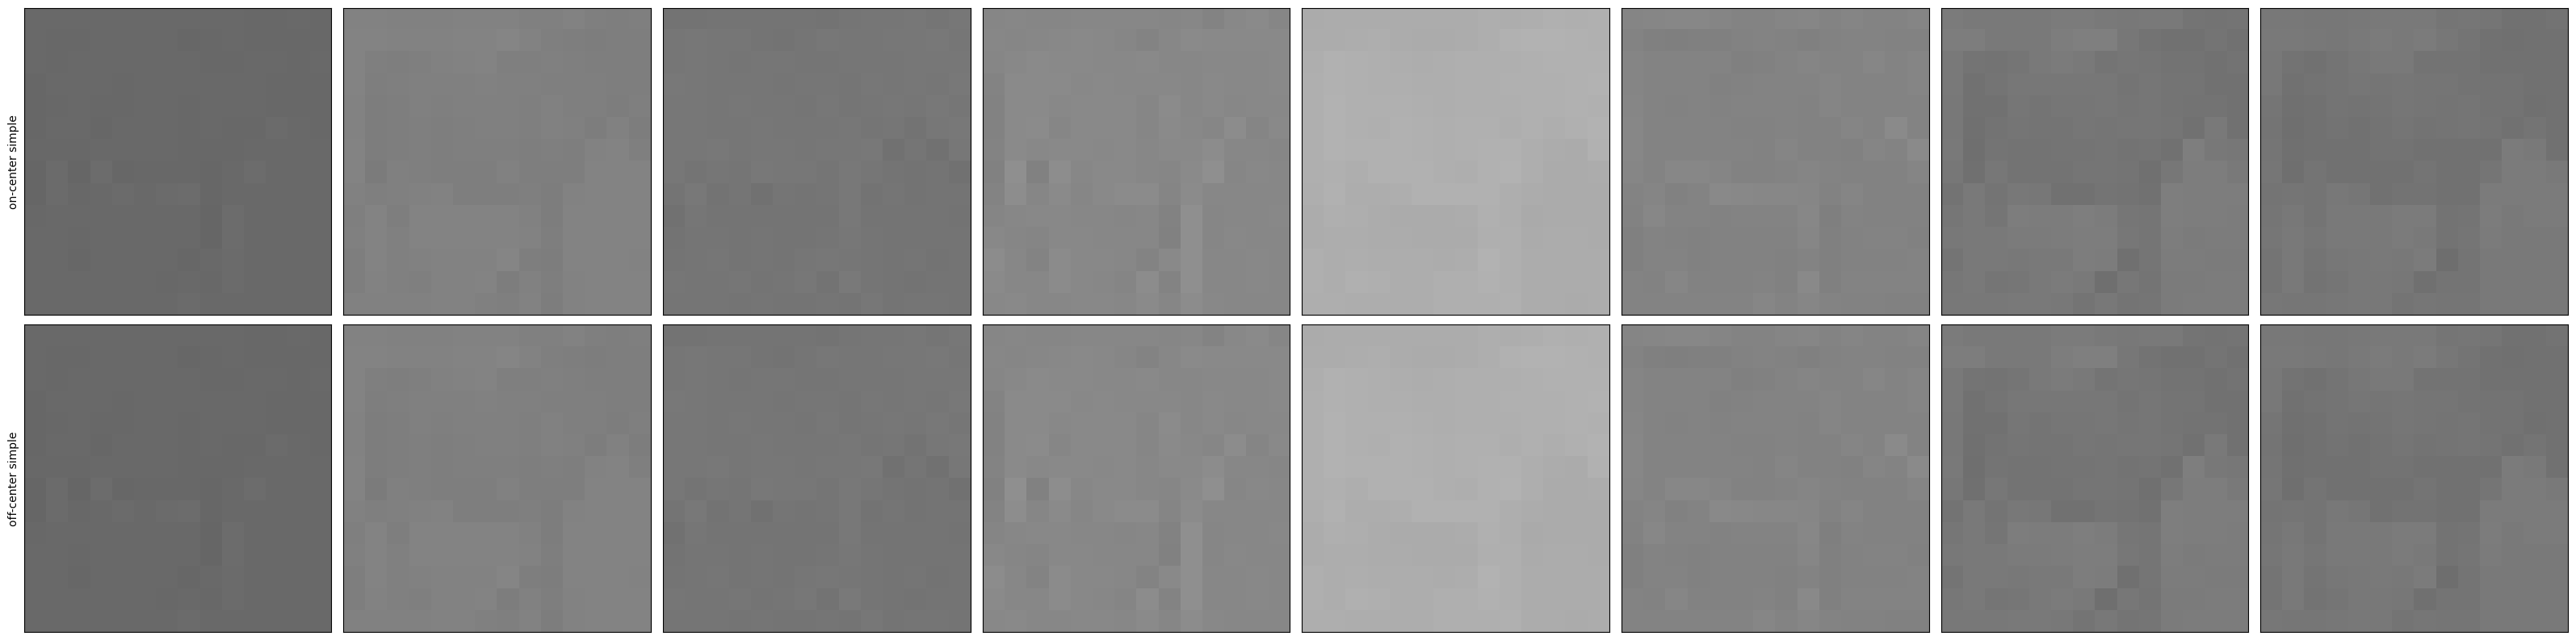

In [6]:
# let's take a look at the simple cell outputs
fig, ax = plt.subplots(2, 8, figsize=(32, 8.25))
s = s.detach().numpy()

for i in range(8):
    ax[0][i].imshow(s[i], cmap="gray", vmin=0, vmax=1)
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
ax[0][0].set_ylabel("on-center simple")

for i in range(8):
    ax[1][i].imshow(s[i], cmap="gray", vmin=0, vmax=1)
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
ax[1][0].set_ylabel("off-center simple")

fig.set_tight_layout(True)
plt.show()

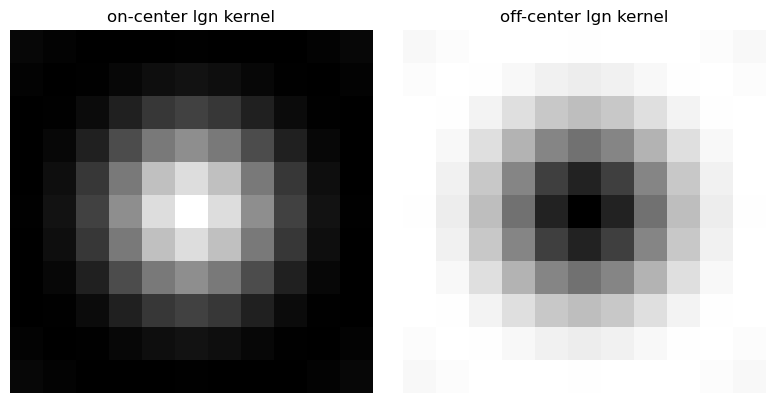

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(*model.lgn_kernel[0], cmap="gray")
ax[0].set_title("on-center lgn kernel")

ax[1].imshow(*model.lgn_kernel[1], cmap="gray")
ax[1].set_title("off-center lgn kernel")

for a in ax:
    a.axis("off")

fig.set_tight_layout(True)
plt.show()